In [1]:
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from model import UNet
from db_modify_array import modify_array

In [2]:
# ## Provide path to T1W image; Specify scan ID;
# image_path = ''
# scan = ''

# ## Provide path to store model averaging ensemble (rounded) prediction;
# path_to_store = ''

In [3]:
## Load T1W image;
## Extract header and affine transformation matrix from nifti header;
## (the following image example is from the training data);
image = nib.load('example_image.nii.gz') ## nib.load(image_path + scan + '_T1W.nii.gz')
header = image.header

## Extract 3D numpy array; normalize image by 3 standard deviation of intensity distribution;
image = image.get_fdata()
image = image / (3 * np.std(image) )

## Modify dimensions, data type to match model required input;
## Output: 4D numpy array of size [N,1,H,W];
image = modify_array(image)
image = torch.from_numpy(image)

In [4]:
## Load models state dictionaries;
## Define model, allocate on GPU, load the parameters, set model to the evaluation mode;
model_1 = UNet(depth = 4, filter_number = 4, kernel_size = 3, padding = 1)
model_1 = model_1.cuda()
model_1.load_state_dict(torch.load('model_1.pt'), strict = True) ## specify model path;
model_1 = model_1.eval()

model_2 = UNet(depth = 4, filter_number = 4, kernel_size = 3, padding = 1)
model_2 = model_2.cuda()
model_2.load_state_dict(torch.load('model_1.pt'), strict = True)
model_2 = model_2.eval()

model_3 = UNet(depth = 4, filter_number = 4, kernel_size = 3, padding = 1)
model_3 = model_3.cuda()
model_3.load_state_dict(torch.load('model_1.pt'), strict = True)
model_3 = model_3.eval()

In [5]:
## Pass input to the models; output: 4D torch tensor of size [N,1,H,W];
## Don't store computational graph;
with torch.no_grad():
    prediction_1 = model_1(image.cuda())
    prediction_2 = model_2(image.cuda())
    prediction_3 = model_3(image.cuda())
    
## Allocate tensors on cpu and convert to numpy arrays;
prediction_1 = prediction_1.cpu().numpy()
prediction_2 = prediction_2.cpu().numpy()
prediction_3 = prediction_3.cpu().numpy()
    
## Average the predictions; round the average prediction;
prediction = (prediction_1 + prediction_2 + prediction_3) / 3.
rounded_prediction = prediction.round()

## Create an array to hold the result; output: 3D numpy array of size [H,W,N];
seg = np.zeros((image.shape[-1], image.shape[-1], image.shape[0]))

#### ---------------------------------------------------------------------- Loop over slices;
for i in range(prediction.shape[0]):
    seg[:,:,i] = rounded_prediction[i,0,:,:]
#### -----------------------------------------------------------------------------------------

In [6]:
## Save the rounded average prediction to the nifti file;
seg = np.rot90(seg, k = 3)
seg = seg.astype('uint16')
nifti = nib.Nifti1Image(seg, None, header)
nifti_header = nifti.header
nifti_header['datatype'] = 512 ## unsigned short;

# nib.save(nifti, path_to_store + scan + '_disease_region')

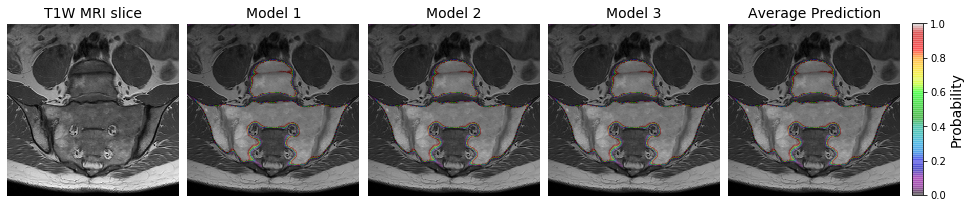

In [7]:
## Visualize models probability maps; select a slice;
s = 10 
fig, a =  plt.subplots(nrows = 1 , ncols = 5, figsize=(16,4))
ax0, ax1, ax2, ax3, ax4 = a[0], a[1], a[2], a[3], a[4]

## Show image slice;
ax0.imshow(image[s,0,:,:], cmap = 'gray')
ax0.set_title('T1W MRI slice', fontsize = 14)
ax0.axis('off')

## Show image slice and the first model prediction (super-imposed);
ax1.imshow(image[s,0,:,:], cmap = 'gray')
ax1.imshow(prediction_1[s,0,:,:], cmap = 'nipy_spectral', alpha = 0.3)
ax1.set_title('Model 1', fontsize = 14)
ax1.axis('off')

## Show image slice and the second model prediction (super-imposed);
ax2.imshow(image[s,0,:,:], cmap = 'gray')
ax2.imshow(prediction_2[s,0,:,:], cmap = 'nipy_spectral', alpha = 0.3)
ax2.set_title('Model 2', fontsize = 14)
ax2.axis('off')

## Show image slice and the third model prediction (super-imposed);
ax3.imshow(image[s,0,:,:], cmap = 'gray')
ax3.imshow(prediction_3[s,0,:,:], cmap = 'nipy_spectral', alpha = 0.3)
ax3.set_title('Model 3', fontsize = 14)
ax3.axis('off')

## Show image slice and model averaging ensemble prediction (super-imposed);
ax4.imshow(image[s,0,:,:], cmap = 'gray')
im = ax4.imshow(prediction[s,0,:,:], cmap = 'nipy_spectral', alpha = 0.3)
ax4.set_title('Average Prediction', fontsize = 14)
ax4.axis('off')

fig.subplots_adjust(wspace = 0.05)

## Add an axes, lower left corner in [0.91, 0.207] measured in figure coordinate
## with axes width 0.01 and height 0.595;
cb_ax = fig.add_axes([0.91, 0.207, 0.01, 0.595])
cbar = fig.colorbar(im, cax = cb_ax)
cbar.set_ticks(np.arange(0, 1.2, 0.2))
cbar.set_label('Probability', fontsize = 14)
plt.show()